In [36]:
# save d as pickle file
import pickle
import pandas as pd
import numpy as np


# load dataset-cleand.picke
with open('dataset-filtred.pickle', 'rb') as f:
    d_filtred = pickle.load(f)

# load dataset-cleand.picke
with open('dataset-filtred-full.pickle', 'rb') as f:
    d_full = pickle.load(f)

with open('dataset_filtred_pesimitsitc.pickle', 'rb') as f:
    d_pesimitsitc = pickle.load(f)

In [37]:
len(d_filtred), len(d_full), len(d_pesimitsitc)

(78, 249, 174)

In [38]:
import torch as th
import torch.nn as nn
import numpy as np
import torch.optim as optim

# create dataset with masked values each next 5min for transforer to predict next token

class MaskedDataSet(th.utils.data.Dataset):
    def __init__(self, data, day_length=169, min_tokens=16):
        self.data = data
        self.day_length = day_length
        self.min_tokens = min_tokens
    
    def __len__(self):
        return len(self.data)*(self.day_length - self.min_tokens) 
    
    def days(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get day index and time index, start from min_tokens
        day_idx = idx // (self.day_length - self.min_tokens)
        time_idx = idx % (self.day_length - self.min_tokens) + self.min_tokens
        
        return self.get_day(day_idx, time_idx)
    
    def get_day(self, day_idx, time_idx):
        # get day data 
        day_data = self.data[day_idx]
        
        # mask day data
        mask = np.ones((self.day_length, len(day_data.columns)), dtype=np.float32)
        mask[time_idx:] = 0
        mask = th.tensor(mask, dtype=th.float32)
        # get y (next token)
        y = day_data.iloc[time_idx].values.astype(np.float32)
        y = th.tensor(y, dtype=th.float32)
        
        # get day data
        day_data = day_data.values.astype(np.float32)
        day_data = th.tensor(day_data, dtype=th.float32)
        day_data = day_data * mask
        
        return day_data, mask, time_idx, y
    
# create dataset
dataset_filtred = MaskedDataSet(d_filtred, day_length=169)
dataset_filtred_full = MaskedDataSet(d_full, day_length=169)
dataset_filtred_pesimitsitc = MaskedDataSet(d_pesimitsitc, day_length=169)

In [5]:
import tqdm

def auto_regression(model, dataset, day, fill):
    with th.no_grad():
        x, mask, mask_idx, _ = dataset.get_day(day, fill)
        x = x.cuda().unsqueeze(0)  # Shape: (1, T, C)
        mask = mask.cuda().unsqueeze(0)
        mask_idx = int(mask_idx)

        for _ in range(168 - mask_idx):
            output = model(x)
            x[:, mask_idx, :] = output.squeeze(1)
            mask[:, mask_idx, :] = 0
            mask_idx += 1

        return x.cpu().numpy()[0]

def test_autoregression(model, dataset):
    # test for autoregression from diffrent timestamps, run autoregression and calculate
    # total energy and true total energy
    collected = []
    with th.no_grad():
        for i in tqdm.trange(5, dataset.days(), 16):
            days = []
            for j in range(32, 169, 16):
                data = dataset.get_day(i, j)
                x, mask, mask_idx, y = data
                XTrue, _, _, _ = dataset.get_day(i, 168)
                x = x.cuda().unsqueeze(0)  # Shape: (1, T, C)
                mask = mask.cuda().unsqueeze(0)
                mask_idx = int(mask_idx)
            
                history = auto_regression(model, dataset, i, j)
                history = np.array(history)
                dataPred = pd.DataFrame(history).clip(lower=0)

                dataTrue = pd.DataFrame(XTrue).clip(lower=0)

                energy = dataPred.loc[:, 0]
                energyTrue = dataTrue.loc[:, 0]
                # print(energy.sum(), energyTrue.sum(), 'error', np.abs(energy - energyTrue).sum(), 'error (total)', np.abs(energy.sum() - energyTrue.sum()))
                days.append([energyTrue, energy])
            collected.append(days)
    return np.array(collected)

In [12]:
from numpy import isnan
import torchsummary
import tqdm
# create transformer model


# input feature size: 5, output feature size: 5
class AutoRegressiveTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, ff_dim, dropout=0.1, seq_len=169):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.pos_emb = nn.Parameter(th.randn(1, seq_len, model_dim))  
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=model_dim, nhead=num_heads, dim_feedforward=ff_dim,
            dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(model_dim, input_dim)  # output same dim as input for prediction

    def generate_square_subsequent_mask(self, sz):
        # Causal mask
        return th.triu(th.ones(sz, sz) * float('-inf'), diagonal=1)

    def forward(self, x):
        B, T, F = x.size()
        x = self.input_proj(x) + self.pos_emb[:, :T, :]
        causal_mask = self.generate_square_subsequent_mask(T).to(x.device)
        output = self.transformer(x, x, tgt_mask=causal_mask)
        # get last token (output)
        output = output[:, -1, :].unsqueeze(1)  # (B, 1, model_dim)
        return self.output_proj(output)


def train_model(dataset, model_dim, num_heads, num_layers, ff_dim, dropout=0.1, epochs=5, model=None):
    if model is None:
        model = AutoRegressiveTransformer(
            input_dim=4,   # Number of features in the input
            model_dim=model_dim,   # Dimension of the model (must be divisible by nhead)
            num_heads=num_heads,   # Number of attention heads
            num_layers=num_layers,  # Number of transformer layers
            ff_dim=ff_dim,     # Feedforward dimension
            dropout=dropout,   # Dropout rate
            seq_len=169    # Sequence length (number of time steps)
        )

    torchsummary.summary(model, input_size=(169, 4))

    dataloader = th.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.cuda()

    losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        batches = tqdm.tqdm(enumerate(dataloader), total=len(dataloader), desc="Training")
        for i, (x, mask, _, y) in batches:
            x = x.cuda()
            y = y.cuda()
            mask = mask.cuda()
            
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output.squeeze(1), y) 
            
            if np.isnan(loss.item()):
                continue
    
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            losses.append(loss.item())
            batches.set_description(f"Epoch {epoch+1}/{epochs}")
            if len(losses) > 10:
                batches.set_postfix(loss=np.mean(losses[-10:]))

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloader)}")
    autoregression_results = test_autoregression(model, dataset)
    errors = np.abs(autoregression_results[:, :, 0, :] - autoregression_results[:, :, 1, :])
    total_error = np.sum(errors, axis=2)
    print('Total error:', total_error.mean(), total_error.std())
    return model, running_loss, total_error

In [24]:
model, losses, autoreg_result = train_model(
    dataset_filtred_full,
    model_dim=16,
    num_heads=8, 
    num_layers=3, 
    ff_dim=96,     
    dropout=0.1,
    epochs=10
)

Layer (type:depth-idx)                        Param #
├─Linear: 1-1                                 80
├─TransformerDecoder: 1-2                     --
|    └─ModuleList: 2-1                        --
|    |    └─TransformerDecoderLayer: 3-1      5,456
|    |    └─TransformerDecoderLayer: 3-2      5,456
|    |    └─TransformerDecoderLayer: 3-3      5,456
├─Linear: 1-3                                 68
Total params: 16,516
Trainable params: 16,516
Non-trainable params: 0


Epoch 1/10: 100%|██████████| 596/596 [00:39<00:00, 14.96it/s, loss=0.0194]


Epoch 1/10, Loss: 0.03571543244226217


Epoch 2/10: 100%|██████████| 596/596 [00:37<00:00, 15.81it/s, loss=0.0129]


Epoch 2/10, Loss: 0.014646509849003847


Epoch 3/10: 100%|██████████| 596/596 [00:39<00:00, 14.98it/s, loss=0.00865]


Epoch 3/10, Loss: 0.010316438889349718


Epoch 4/10: 100%|██████████| 596/596 [00:38<00:00, 15.49it/s, loss=0.00787]


Epoch 4/10, Loss: 0.008257617284043773


Epoch 5/10: 100%|██████████| 596/596 [00:37<00:00, 15.98it/s, loss=0.00657]


Epoch 5/10, Loss: 0.006925865692936584


Epoch 6/10: 100%|██████████| 596/596 [00:37<00:00, 16.04it/s, loss=0.006]  


Epoch 6/10, Loss: 0.006247749028261751


Epoch 7/10: 100%|██████████| 596/596 [00:37<00:00, 16.06it/s, loss=0.00572]


Epoch 7/10, Loss: 0.005614623899693482


Epoch 8/10: 100%|██████████| 596/596 [00:37<00:00, 16.05it/s, loss=0.00437]


Epoch 8/10, Loss: 0.005118018245143228


Epoch 9/10: 100%|██████████| 596/596 [00:37<00:00, 15.99it/s, loss=0.00425]


Epoch 9/10, Loss: 0.004737415093141014


Epoch 10/10: 100%|██████████| 596/596 [00:37<00:00, 16.02it/s, loss=0.00422]


Epoch 10/10, Loss: 0.00446469125989512


100%|██████████| 16/16 [00:55<00:00,  3.45s/it]

Total error: 7.0891757 6.180719


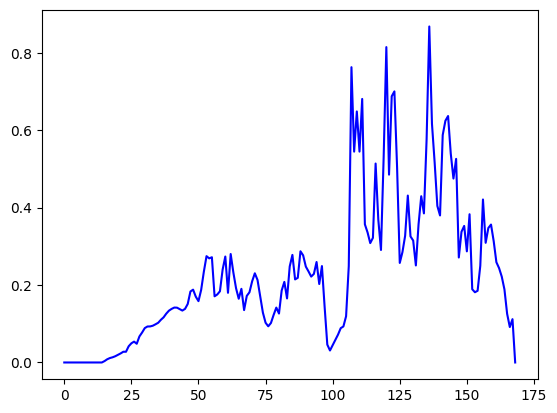

Generating prediction history: 100%|██████████| 153/153 [01:01<00:00,  2.47it/s]


(153, 169, 4)

In [25]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import torch as th


# Constants
DAY = 60
FILL_VALUES = list(range(16, 169))  # Fill from 16 to 168

# Get the ground truth for comparison
x_True, _, _, _ = dataset_filtred_full.get_day(DAY, 168)
x_true_np = x_True[:, 0].cpu().numpy()

# Run autoregression for each fill value
all_predictions = []
start_indices = []

plt.clf()
plt.plot(x_true_np, label='True', color='blue')
plt.show()

for fill in tqdm.tqdm(FILL_VALUES, desc="Generating prediction history"):
    preds = auto_regression(model, dataset_filtred_full, DAY, fill)
    all_predictions.append(preds)
    start_indices.append(int(dataset_filtred_full.get_day(DAY, fill)[2]))

all_predictions = np.array(all_predictions)
start_indices = np.array(start_indices)

all_predictions.shape

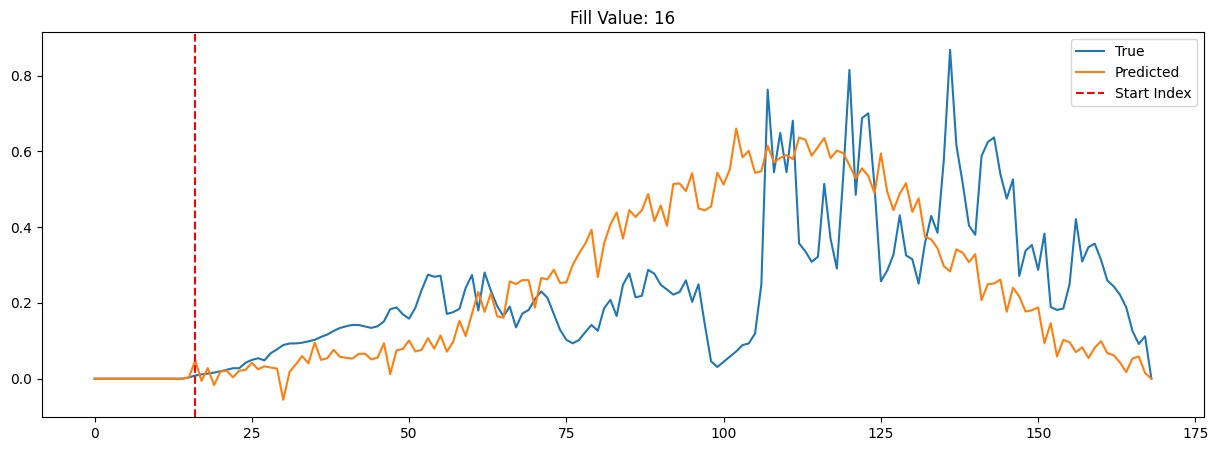

In [26]:
# create gif animation of predictions

def update(frame):
    plt.clf()
    plt.plot(x_true_np, label='True')
    plt.plot(all_predictions[frame, :, 0], label='Predicted')
    plt.axvline(x=start_indices[frame], color='r', linestyle='--', label='Start Index')
    plt.title(f"Fill Value: {FILL_VALUES[frame]}")
    plt.legend()

fig = plt.figure(figsize=(15, 5))
ani = FuncAnimation(fig, update, frames=len(FILL_VALUES), repeat=True)
# Save the animation as a GIF
ani.save('autoregression_fine_tuned_on_filtred_full.gif', writer=PillowWriter(fps=10), dpi=100)

In [ ]:
# save model as final-full.pth
th.save(model.state_dict(), 'final-full.pth')

In [28]:
# fine tune the model on filtred dataset
model, losses, autoreg_result = train_model(
    dataset_filtred,
    model_dim=16,
    num_heads=8, 
    num_layers=3, 
    ff_dim=96,     
    dropout=0.1,
    epochs=10,
    model=model
)

Layer (type:depth-idx)                        Param #
├─Linear: 1-1                                 80
├─TransformerDecoder: 1-2                     --
|    └─ModuleList: 2-1                        --
|    |    └─TransformerDecoderLayer: 3-1      5,456
|    |    └─TransformerDecoderLayer: 3-2      5,456
|    |    └─TransformerDecoderLayer: 3-3      5,456
├─Linear: 1-3                                 68
Total params: 16,516
Trainable params: 16,516
Non-trainable params: 0


Epoch 1/10: 100%|██████████| 187/187 [00:11<00:00, 15.64it/s, loss=0.00335]


Epoch 1/10, Loss: 0.003476218870133759


Epoch 2/10: 100%|██████████| 187/187 [00:11<00:00, 15.96it/s, loss=0.0027] 


Epoch 2/10, Loss: 0.003252723265469154


Epoch 3/10: 100%|██████████| 187/187 [00:11<00:00, 15.94it/s, loss=0.00314]


Epoch 3/10, Loss: 0.003118806694171088


Epoch 4/10: 100%|██████████| 187/187 [00:11<00:00, 16.01it/s, loss=0.00283]


Epoch 4/10, Loss: 0.0029917465906371087


Epoch 5/10: 100%|██████████| 187/187 [00:11<00:00, 15.98it/s, loss=0.00305]


Epoch 5/10, Loss: 0.0027864012489951947


Epoch 6/10: 100%|██████████| 187/187 [00:11<00:00, 15.94it/s, loss=0.0036] 


Epoch 6/10, Loss: 0.0028180342452740047


Epoch 7/10: 100%|██████████| 187/187 [00:11<00:00, 15.97it/s, loss=0.00297]


Epoch 7/10, Loss: 0.002631592302194692


Epoch 8/10: 100%|██████████| 187/187 [00:11<00:00, 16.03it/s, loss=0.00227]


Epoch 8/10, Loss: 0.0025884437376015724


Epoch 9/10: 100%|██████████| 187/187 [00:11<00:00, 16.11it/s, loss=0.00237]


Epoch 9/10, Loss: 0.0025521952355091267


Epoch 10/10: 100%|██████████| 187/187 [00:11<00:00, 16.09it/s, loss=0.00234]


Epoch 10/10, Loss: 0.0024754134782485385


100%|██████████| 5/5 [00:17<00:00,  3.55s/it]

Total error: 3.3031423 2.5723586


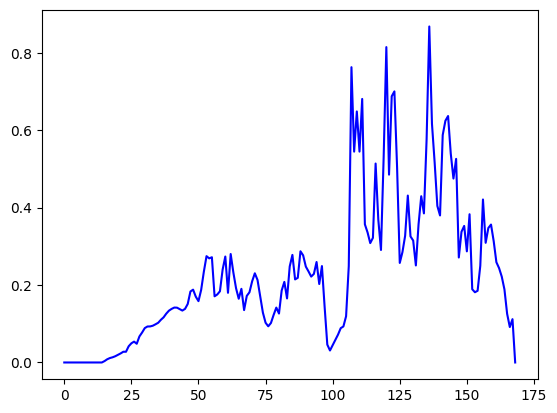

Generating prediction history: 100%|██████████| 153/153 [01:01<00:00,  2.47it/s]


(153, 169, 4)

In [29]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import torch as th

# Constants
DAY = 60
FILL_VALUES = list(range(16, 169))  # Fill from 16 to 168

# Get the ground truth for comparison
x_True, _, _, _ = dataset_filtred_full.get_day(DAY, 168)
x_true_np = x_True[:, 0].cpu().numpy()

# Run autoregression for each fill value
all_predictions = []
start_indices = []

plt.clf()
plt.plot(x_true_np, label='True', color='blue')
plt.show()

for fill in tqdm.tqdm(FILL_VALUES, desc="Generating prediction history"):
    preds = auto_regression(model, dataset_filtred_full, DAY, fill)
    all_predictions.append(preds)
    start_indices.append(int(dataset_filtred_full.get_day(DAY, fill)[2]))

all_predictions = np.array(all_predictions)
start_indices = np.array(start_indices)

all_predictions.shape

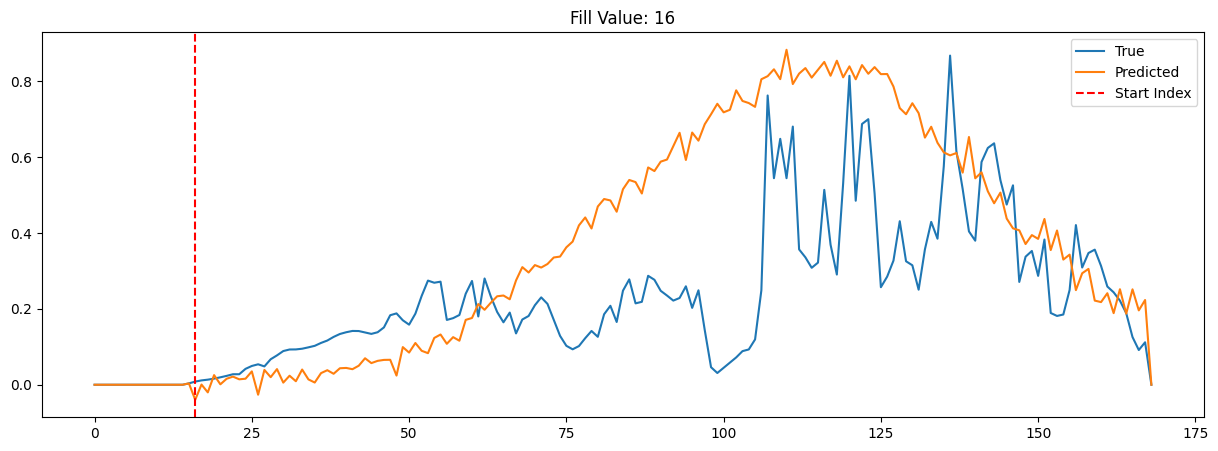

In [30]:
fig = plt.figure(figsize=(15, 5))
ani = FuncAnimation(fig, update, frames=len(FILL_VALUES), repeat=True)
# Save the animation as a GIF
ani.save('autoregression_fine_tuned_on_filtred.gif', writer=PillowWriter(fps=10), dpi=100)

In [ ]:
# save model as final-filtred.pth
th.save(model.state_dict(), 'final-filtred.pth')

In [59]:
def train_model(dataset, model_dim, num_heads, num_layers, ff_dim, dropout=0.1, epochs=5, model=None):
    if model is None:
        model = AutoRegressiveTransformer(
            input_dim=4,   # Number of features in the input
            model_dim=model_dim,   # Dimension of the model (must be divisible by nhead)
            num_heads=num_heads,   # Number of attention heads
            num_layers=num_layers,  # Number of transformer layers
            ff_dim=ff_dim,     # Feedforward dimension
            dropout=dropout,   # Dropout rate
            seq_len=169    # Sequence length (number of time steps)
        )

    torchsummary.summary(model, input_size=(169, 4))

    dataloader = th.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.cuda()

    losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        batches = tqdm.tqdm(enumerate(dataloader), total=len(dataloader), desc="Training")
        for i, (x, mask, _, y) in batches:
            x = x.cuda()
            y = y.cuda()
            mask = mask.cuda()
            
            optimizer.zero_grad()
            output = model(x).squeeze(1)
            # loss for overshooting the target
            overshoot_loss = th.mean(th.relu(output - y)**2)
            loss = criterion(output, y) + overshoot_loss * 2
            
            if np.isnan(loss.item()):
                continue
    
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            losses.append(loss.item())
            batches.set_description(f"Epoch {epoch+1}/{epochs}")
            if len(losses) > 10:
                batches.set_postfix(loss=np.mean(losses[-10:]))

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloader)}")
    autoregression_results = test_autoregression(model, dataset)
    errors = np.abs(autoregression_results[:, :, 0, :] - autoregression_results[:, :, 1, :])
    total_error = np.sum(errors, axis=2)
    print('Total error:', total_error.mean(), total_error.std())
    return model, running_loss, total_error
# train on dataset_filtred_pesimitsitc
model, losses, autoreg_result = train_model(
    dataset_filtred_pesimitsitc,
    model_dim=16,
    num_heads=8, 
    num_layers=3, 
    ff_dim=96,     
    dropout=0.1,
    epochs=10,
)

Layer (type:depth-idx)                        Param #
├─Linear: 1-1                                 80
├─TransformerDecoder: 1-2                     --
|    └─ModuleList: 2-1                        --
|    |    └─TransformerDecoderLayer: 3-1      5,456
|    |    └─TransformerDecoderLayer: 3-2      5,456
|    |    └─TransformerDecoderLayer: 3-3      5,456
├─Linear: 1-3                                 68
Total params: 16,516
Trainable params: 16,516
Non-trainable params: 0


Epoch 1/10: 100%|██████████| 416/416 [00:26<00:00, 15.72it/s, loss=0.0369]


Epoch 1/10, Loss: 0.06456948440217485


Epoch 2/10: 100%|██████████| 416/416 [00:25<00:00, 16.05it/s, loss=0.0201]


Epoch 2/10, Loss: 0.027363055137147266


Epoch 3/10: 100%|██████████| 416/416 [00:25<00:00, 16.10it/s, loss=0.0155]


Epoch 3/10, Loss: 0.019194541519167475


Epoch 4/10: 100%|██████████| 416/416 [00:25<00:00, 16.15it/s, loss=0.0136]


Epoch 4/10, Loss: 0.014885347602942672


Epoch 5/10: 100%|██████████| 416/416 [00:25<00:00, 16.14it/s, loss=0.0122]


Epoch 5/10, Loss: 0.012755088605515014


Epoch 6/10: 100%|██████████| 416/416 [00:25<00:00, 16.13it/s, loss=0.0114] 


Epoch 6/10, Loss: 0.01124457672099547


Epoch 7/10: 100%|██████████| 416/416 [00:25<00:00, 16.08it/s, loss=0.00923]


Epoch 7/10, Loss: 0.01055759696352582


Epoch 8/10: 100%|██████████| 416/416 [00:25<00:00, 16.10it/s, loss=0.009]  


Epoch 8/10, Loss: 0.009755887628461305


Epoch 9/10: 100%|██████████| 416/416 [00:25<00:00, 16.15it/s, loss=0.00918]


Epoch 9/10, Loss: 0.009227296028536959


Epoch 10/10: 100%|██████████| 416/416 [00:25<00:00, 16.11it/s, loss=0.00845]


Epoch 10/10, Loss: 0.008750751359352412


100%|██████████| 11/11 [00:44<00:00,  4.01s/it]

Total error: 6.7677064 7.183744


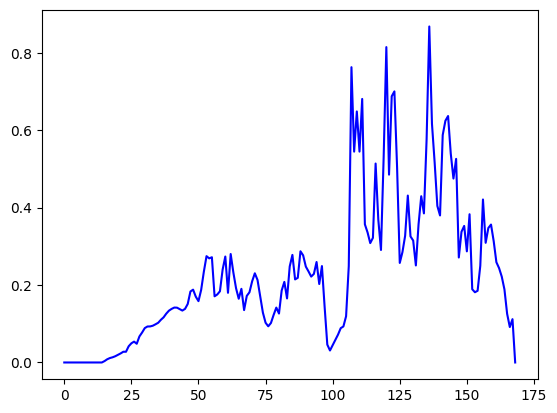

Generating prediction history: 100%|██████████| 153/153 [01:05<00:00,  2.34it/s]


(153, 169, 4)

In [60]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import torch as th

# Constants
DAY = 60
FILL_VALUES = list(range(16, 169))  # Fill from 16 to 168

# Get the ground truth for comparison
x_True, _, _, _ = dataset_filtred_full.get_day(DAY, 168)
x_true_np = x_True[:, 0].cpu().numpy()

# Run autoregression for each fill value
all_predictions = []
start_indices = []

plt.clf()
plt.plot(x_true_np, label='True', color='blue')
plt.show()

for fill in tqdm.tqdm(FILL_VALUES, desc="Generating prediction history"):
    preds = auto_regression(model, dataset_filtred_full, DAY, fill)
    all_predictions.append(preds)
    start_indices.append(int(dataset_filtred_full.get_day(DAY, fill)[2]))

all_predictions = np.array(all_predictions)
start_indices = np.array(start_indices)

all_predictions.shape

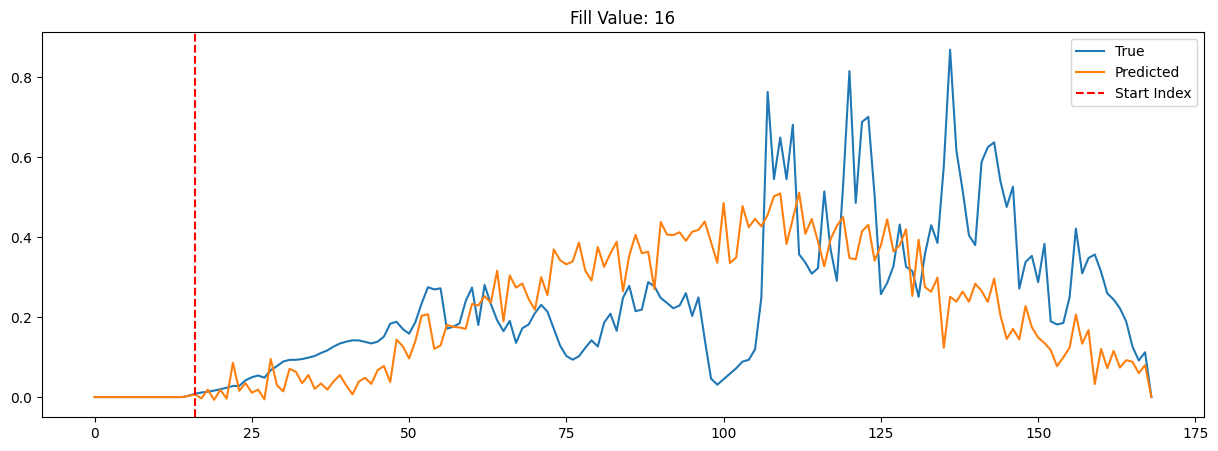

In [61]:
fig = plt.figure(figsize=(15, 5))
def update(frame):
    plt.clf()
    plt.plot(x_true_np, label='True')
    plt.plot(all_predictions[frame, :, 0], label='Predicted')
    plt.axvline(x=start_indices[frame], color='r', linestyle='--', label='Start Index')
    plt.title(f"Fill Value: {FILL_VALUES[frame]}")
    plt.legend()
ani = FuncAnimation(fig, update, frames=len(FILL_VALUES), repeat=True)
# Save the animation as a GIF
ani.save('autoregression_fine_tuned_on_filtred_pesimistic.gif', writer=PillowWriter(fps=10), dpi=100)

In [62]:
# save model as final-filtred-pesimistic.pth
th.save(model.state_dict(), 'final-filtred-pesimistic.pth')

C:\Users\Maciej\AppData\Local\Temp\ipykernel_18984\1842598191.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_full.load_state_dict(th.load('final-full.pth'))
C:\U

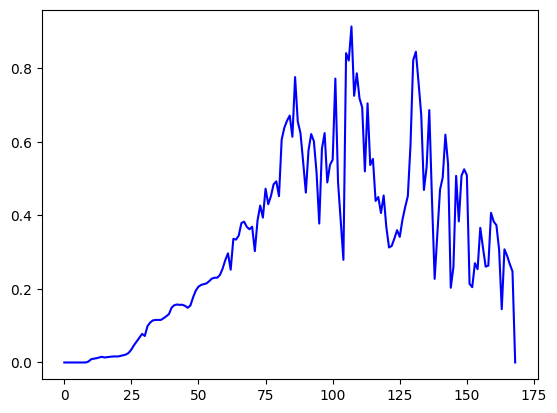

Generating prediction history: 100%|██████████| 77/77 [01:29<00:00,  1.16s/it]


(153, 169, 4)

In [63]:
# load all 3 models and create plot of every prediction
model_full = AutoRegressiveTransformer(
    input_dim=4,   # Number of features in the input
    model_dim=16,   # Dimension of the model (must be divisible by nhead)
    num_heads=8,   # Number of attention heads
    num_layers=3,  # Number of transformer layers
    ff_dim=96,     # Feedforward dimension
    dropout=0.1,   # Dropout rate
    seq_len=169    # Sequence length (number of time steps)
).cuda()
model_full.load_state_dict(th.load('final-full.pth'))

model_pesimistic = AutoRegressiveTransformer(
    input_dim=4,   # Number of features in the input
    model_dim=16,   # Dimension of the model (must be divisible by nhead)
    num_heads=8,   # Number of attention heads
    num_layers=3,  # Number of transformer layers
    ff_dim=96,     # Feedforward dimension
    dropout=0.1,   # Dropout rate
    seq_len=169    # Sequence length (number of time steps)
).cuda()
model_pesimistic.load_state_dict(th.load('final-filtred-pesimistic.pth'))

model_filtred = AutoRegressiveTransformer(
    input_dim=4,   # Number of features in the input
    model_dim=16,   # Dimension of the model (must be divisible by nhead)
    num_heads=8,   # Number of attention heads
    num_layers=3,  # Number of transformer layers
    ff_dim=96,     # Feedforward dimension
    dropout=0.1,   # Dropout rate
    seq_len=169    # Sequence length (number of time steps)
).cuda()
model_filtred.load_state_dict(th.load('final-filtred.pth'))

# Constants
DAY = 40
FILL_VALUES = list(range(16, 169, 2))  # Fill from 16 to 168

# Get the ground truth for comparison
x_True, _, _, _ = dataset_filtred_full.get_day(DAY, 168)
x_true_np = x_True[:, 0].cpu().numpy()

# Run autoregression for each fill value
all_predictions_full = []
all_predictions_pesimistic = []
all_predictions_filtred = []
start_indices = []

plt.clf()
plt.plot(x_true_np, label='True', color='blue')
plt.show()

for fill in tqdm.tqdm(FILL_VALUES, desc="Generating prediction history"):
    preds_full = auto_regression(model_full, dataset_filtred_full, DAY, fill)
    preds_pesimistic = auto_regression(model_pesimistic, dataset_filtred_full, DAY, fill)
    preds_filtred = auto_regression(model_filtred, dataset_filtred_full, DAY, fill)
    all_predictions_full.append(preds_full)
    all_predictions_pesimistic.append(preds_pesimistic) 
    all_predictions_filtred.append(preds_filtred)
    start_indices.append(int(dataset_filtred_full.get_day(DAY, fill)[2]))

all_predictions = np.array(all_predictions)
all_predictions_full = np.array(all_predictions_full)
all_predictions_pesimistic = np.array(all_predictions_pesimistic)
all_predictions_filtred = np.array(all_predictions_filtred)
start_indices = np.array(start_indices)

all_predictions.shape

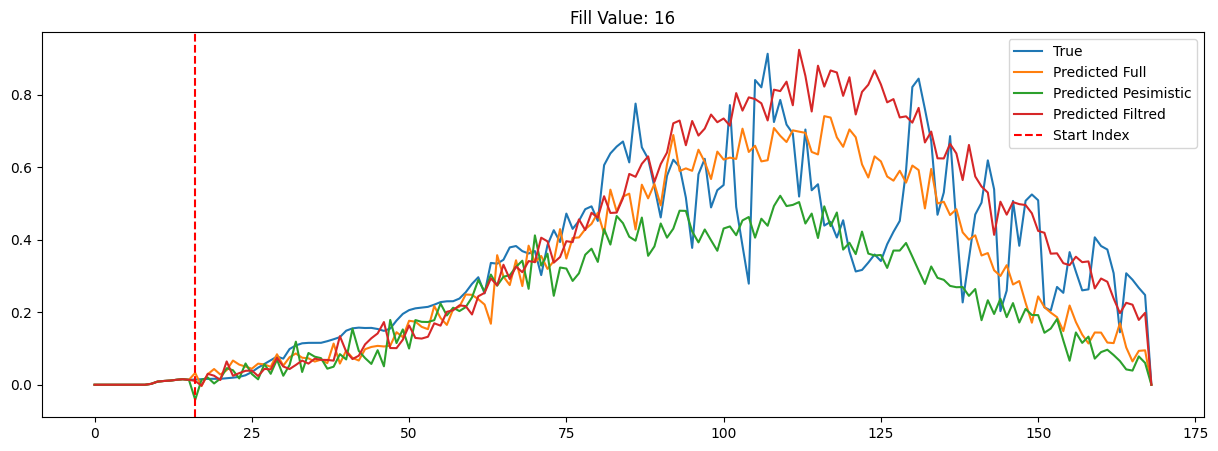

In [64]:
fig = plt.figure(figsize=(15, 5))
def update(frame):
    plt.clf()
    plt.plot(x_true_np, label='True')
    plt.plot(all_predictions_full[frame, :, 0], label='Predicted Full')
    plt.plot(all_predictions_pesimistic[frame, :, 0], label='Predicted Pesimistic')
    plt.plot(all_predictions_filtred[frame, :, 0], label='Predicted Filtred')
    plt.axvline(x=start_indices[frame], color='r', linestyle='--', label='Start Index')
    plt.title(f"Fill Value: {FILL_VALUES[frame]}")
    plt.legend()

ani = FuncAnimation(fig, update, frames=len(FILL_VALUES), repeat=True)
# Save the animation as a GIF
ani.save('autoregression_fine_tuned_on_filtred_full_pesimistic.gif', writer=PillowWriter(fps=5), dpi=100)